In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet

In [13]:
DATASET_PATH = "/kaggle/input/archive"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

In [14]:
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
def load_data_from_directory(base_path, emotions, img_size=(48, 48)):
    images = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(emotions)}  # Tạo map nhãn
    for label in emotions:
        label_dir = os.path.join(base_path, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize ảnh về kích thước 48x48
                images.append(img)
                labels.append(label_map[label])
    return np.array(images), np.array(labels), label_map

In [15]:
X_train, y_train, label_map_train = load_data_from_directory(TRAIN_PATH, EMOTIONS)
X_test, y_test, label_map_test = load_data_from_directory(TEST_PATH, EMOTIONS)

# Chuẩn hóa dữ liệu
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode nhãn
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(EMOTIONS))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(EMOTIONS))

# Kiểm tra kích thước dữ liệu
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (28709, 48, 48, 3), y_train shape: (28709, 7)
X_test shape: (7178, 48, 48, 3), y_test shape: (7178, 7)


In [16]:
img_width, img_height, img_depth = X_train.shape[1:]
num_classes = y_train.shape[1]

mobile_net = MobileNet(
    input_shape=(img_width, img_height, img_depth),
    include_top=False,
    weights="imagenet"
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

/tmp/ipykernel_23/2492022539.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = MobileNet(


In [17]:
# Đóng băng các lớp đầu tiên
for layer in model.layers[:15]:
    layer.trainable = False

# Biến đổi dữ liệu cho tăng cường
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [18]:
# Callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

callbacks = [early_stopping, lr_scheduler]
# Biên dịch mô hình
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)


In [19]:
# Huấn luyện mô hình
batch_size = 32
epochs = 100

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.3829 - loss: 1.7484 - val_accuracy: 0.4971 - val_loss: 1.3286 - learning_rate: 0.0010
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5106 - loss: 1.2914 - val_accuracy: 0.5422 - val_loss: 1.2427 - learning_rate: 0.0010
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5455 - loss: 1.2042 - val_accuracy: 0.5553 - val_loss: 1.1536 - learning_rate: 0.0010
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5587 - loss: 1.1677 - val_accuracy: 0.5765 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5726 - loss: 1.1317 - val_accuracy: 0.5954 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5757 - loss: 1.1168 - val_accuracy: 0.5632 - val_loss: 1.1707 - learning_rate: 0.0010
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.6009 - loss: 

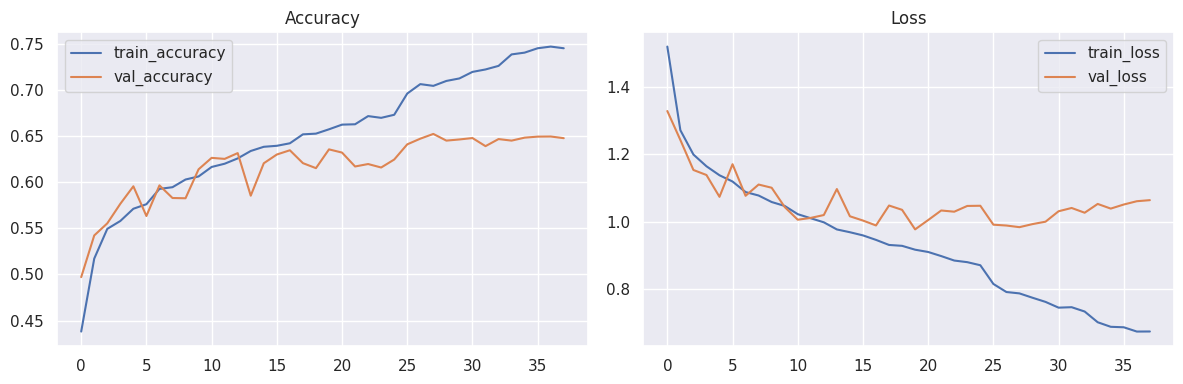

In [20]:
# Vẽ biểu đồ lịch sử huấn luyện
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Biểu đồ Accuracy
axs[0].plot(history.history["accuracy"], label="train_accuracy")
axs[0].plot(history.history["val_accuracy"], label="val_accuracy")
axs[0].set_title("Accuracy")
axs[0].legend()

# Biểu đồ Loss
axs[1].plot(history.history["loss"], label="train_loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].set_title("Loss")
axs[1].legend()

plt.tight_layout()
plt.savefig("training_history.png")
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


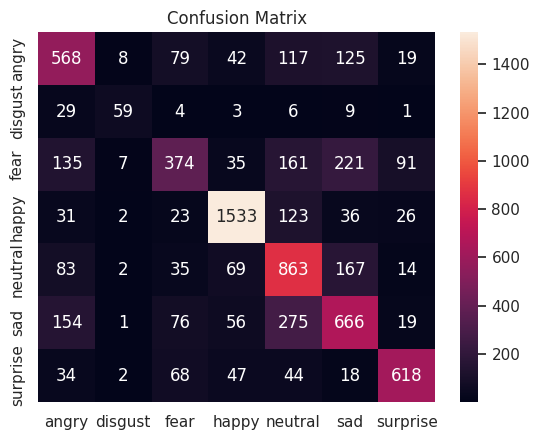

Test Accuracy: 65.21%
Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.59      0.57       958
     disgust       0.73      0.53      0.61       111
        fear       0.57      0.37      0.44      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.54      0.70      0.61      1233
         sad       0.54      0.53      0.54      1247
    surprise       0.78      0.74      0.76       831

    accuracy                           0.65      7178
   macro avg       0.65      0.62      0.63      7178
weighted avg       0.66      0.65      0.65      7178



In [21]:
# Đánh giá mô hình
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

test_accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTIONS))

In [23]:
# Lưu mô hình
model.save("emotion_recognition_model.h5")